In [1]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf

print( "Tensorflow version: ", tf.__version__ )
print( "KERAS version: ", tf.keras.__version__ )

import os
import numpy as np

import matplotlib.pyplot as plt
import scipy.signal
import pickle
import h5py
from tqdm import trange
from evaluator_pk import evaluate_dataset

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


Tensorflow version:  2.4.1
KERAS version:  2.4.0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 837337857279509235
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15476363136
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7824905688622102556
physical_device_desc: "device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0001:00:00.0, compute capability: 7.0"
]


In [2]:
from tensorflow.keras.models import model_from_yaml
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Dense, Concatenate, Add, Lambda
from tensorflow.keras.models import Model



def create_model9pk( w, conv_channels=[32,32,20,4,4] ):
    
    #reg = None
    def make_regularizer():
        return None
    #    return tf.keras.regularizers.L2(l2=0.05)
    
    
    input_data = Input( shape=(w,1),dtype=tf.float32 )
    
    l_ = Conv1D(conv_channels[0], kernel_size=3, kernel_regularizer=make_regularizer(), padding="same", use_bias=True, activation="relu", name="C0")(input_data)
    
    l_ = Conv1D(conv_channels[1], kernel_size=3, kernel_regularizer=make_regularizer(), padding="same", use_bias=True, activation="relu", name="C1")( l_ )
    
    l_ = MaxPooling1D( pool_size=2, name="M0" )( l_ )
    
    l_ = Conv1D(conv_channels[2], kernel_size=3, kernel_regularizer=make_regularizer(), padding="same", use_bias=True, activation="relu", name="C2")( l_ )
        
    l_ = MaxPooling1D( pool_size=2, name="M1" )( l_ )
    
    l_ = Conv1D(conv_channels[3], kernel_size=3, kernel_regularizer=make_regularizer(), padding="same", use_bias=True, activation="relu", name="C3" )( l_ )
    
    topl_ = MaxPooling1D( pool_size=2, name="M2" )( l_ )
        
    # Feature probability
    l_ = Conv1D(conv_channels[4], kernel_size=5, kernel_regularizer=tf.keras.regularizers.L2(l2=0.01), padding="same", use_bias=True, activation="relu", name="RC4")( topl_ )
    #l_ = MaxPooling1D( pool_size=2, name="M3" )( l_ )
    featprobl_ = Conv1D(1, kernel_size=3, padding="same", use_bias=True, activation="sigmoid", name="featprob")( l_ )
        
    #out = Concatenate()( [featprobl_,featprobl_,featprobl_,featprobl_] )
    model = Model(inputs=input_data, outputs=featprobl_, trainable=True, name="MODEL9pk" )
    return model


with tf.Graph().as_default():
    model = create_model9pk(1024)
    print( model.summary())

Model: "MODEL9pk"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1024, 1)]         0         
_________________________________________________________________
C0 (Conv1D)                  (None, 1024, 32)          128       
_________________________________________________________________
C1 (Conv1D)                  (None, 1024, 32)          3104      
_________________________________________________________________
M0 (MaxPooling1D)            (None, 512, 32)           0         
_________________________________________________________________
C2 (Conv1D)                  (None, 512, 20)           1940      
_________________________________________________________________
M1 (MaxPooling1D)            (None, 256, 20)           0         
_________________________________________________________________
C3 (Conv1D)                  (None, 256, 4)            244

In [3]:
from tensorflow.keras.losses import binary_crossentropy, mean_squared_error , kullback_leibler_divergence
    
def weighted_binary_crossentropy( y_true, y_pred, weight=1. ) :
    y_true = tf.keras.backend.clip(y_true, tf.keras.backend.epsilon(), 1-tf.keras.backend.epsilon())
    y_pred = tf.keras.backend.clip(y_pred, tf.keras.backend.epsilon(), 1-tf.keras.backend.epsilon())
    logloss = -(y_true * tf.math.log(y_pred) * weight + (1 - y_true) * tf.math.log(1 - y_pred))
    return tf.reduce_mean( logloss, axis=-1)

def binary_loss( yTrue, yPred ):
    return weighted_binary_crossentropy( 1-yTrue[:,:,0], 1-yPred[:,:,0], weight=0.1 )  
    
def accuracy( yTrue, yPred):     
    pred_yes = tf.cast( yPred[:,:,0]>0.8, dtype=tf.float32 )
    gt_yes = tf.cast( yTrue[:,:,0]>0.8, dtype=tf.float32 )
    
    true_positive = tf.reduce_sum( pred_yes * gt_yes )
    true_negative =  tf.reduce_sum( (1-pred_yes) * (1-gt_yes) )
    num_values = tf.reduce_sum(yTrue[:,:,0]*0 + 1)
    return ( true_positive+true_negative  ) / num_values

def false_positives( yTrue, yPred):
    pred_yes = tf.cast( yPred[:,:,0]>0.8, dtype=tf.float32 )
    gt_no = tf.cast( yTrue[:,:,0]<0.8, dtype=tf.float32 )
    false_positive = tf.reduce_sum( pred_yes * gt_no )
    return false_positive

def false_negatives( yTrue, yPred):
    pred_no = tf.cast( yPred[:,:,0]<0.8, dtype=tf.float32 )
    gt_yes = tf.cast( yTrue[:,:,0]>0.8, dtype=tf.float32 )
    false_negative = tf.reduce_sum( pred_no * gt_yes )
    return false_negative
    
def lossfun( yTrue, yPred, alpha=1.0, beta=1.0, gamma=1.0 ):
    aux = alpha*binary_loss( yTrue, yPred )
    return aux


# Train

In [4]:
def train_model( model, batch_size=256, learning_rate = 1E-3, decay_rate = 0.0, epochs = 50):

    rop = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1,
                                               patience=2, min_lr=1E-6, verbose=1)

    history = tf.keras.callbacks.History()


    with h5py.File("data/train_pk_100k_128.h5",'r') as f:
        x_train = f["x"]
        y_train = f["y"]
        print(y_train.shape)

        model.compile( loss=binary_loss, 
                      optimizer=tf.keras.optimizers.Adam( learning_rate=learning_rate ),# epsilon=1E-4 ), 
                      #optimizer=tf.keras.optimizers.Adadelta(), 
                      metrics=[binary_loss,false_positives,false_negatives,accuracy ] )
                      


        model.fit( x = x_train,
                 y = y_train,
                 batch_size = batch_size,
                 shuffle = "batch",
                 epochs=epochs,
                 callbacks=[history,rop], #[rop, early_stop, tboardcb, checkpoint],
                 verbose=1)
        
    return model


In [5]:
with tf.Graph().as_default():
    model = create_model9pk(1024)
    model = train_model( model, batch_size=128, learning_rate = 1E-3, decay_rate = 0.0, epochs = 10)
    
    model_json = model.to_json()

    model.save_weights("data/last_model9pk_tf2_trained.h5")
    print("Model weights saved.")

    with open("data/last_model9pk_tf2_trained.json", "w") as json_file:
        json_file.write(model_json)  
        print("Model saved to disk") 

(79043, 128, 1)
Train on 79043 samples
Epoch 1/10
79043/79043 [==============================] - 66s 835us/sample - loss: 0.0250 - binary_loss: 0.0169 - false_positives: 64.8754 - false_negatives: 35.9660 - accuracy: 0.9938
Epoch 2/10
79043/79043 [==============================] - 5s 69us/sample - loss: 0.0042 - binary_loss: 0.0037 - false_positives: 22.0906 - false_negatives: 14.4045 - accuracy: 0.9978
Epoch 3/10
79043/79043 [==============================] - 5s 69us/sample - loss: 0.0034 - binary_loss: 0.0032 - false_positives: 17.9595 - false_negatives: 12.7330 - accuracy: 0.9981
Epoch 4/10
79043/79043 [==============================] - 5s 69us/sample - loss: 0.0031 - binary_loss: 0.0029 - false_positives: 16.5663 - false_negatives: 11.6796 - accuracy: 0.9983
Epoch 5/10
79043/79043 [==============================] - 5s 69us/sample - loss: 0.0030 - binary_loss: 0.0028 - false_positives: 15.2395 - false_negatives: 11.2023 - accuracy: 0.9984
Epoch 6/10
79043/79043 [====================

# Model evaluation

In [6]:
%load_ext autoreload
%autoreload 1
%aimport evaluator

with tf.Graph().as_default():
    
    from tensorflow.keras.models import model_from_json
    model = None
    with open("data/last_model9pk_tf2_trained.json", "r") as json_file:
        loaded_model_json = json_file.read()
        model = model_from_json(loaded_model_json)
    
    print(model.summary())
    model.load_weights("data/last_model9pk_tf2_trained.h5")

    print( evaluate_dataset( "data/test_pk_100k_128.h5", model, drawplots=True, saveplots=True ) )

Model: "MODEL9pk"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1024, 1)]         0         
_________________________________________________________________
C0 (Conv1D)                  (None, 1024, 32)          128       
_________________________________________________________________
C1 (Conv1D)                  (None, 1024, 32)          3104      
_________________________________________________________________
M0 (MaxPooling1D)            (None, 512, 32)           0         
_________________________________________________________________
C2 (Conv1D)                  (None, 512, 20)           1940      
_________________________________________________________________
M1 (MaxPooling1D)            (None, 256, 20)           0         
_________________________________________________________________
C3 (Conv1D)                  (None, 256, 4)            244

/DATA/miniconda3/envs/connect2/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


1.0
Confusion matrix (%):
=-=-=-=-=-=-=-=-=-=-=-
                         Yes       No   <-    Predicted peak 
Actual peak  Yes  >    1.8732     0.0720
              No  >    0.0385     98.0163

 Accuracy: 0.99890
Precision: 0.97987
   Recall: 0.96298
(0.998895090413173, 0.9798740840127981, 0.9629779896541231)


# Layer pruning

In [7]:
import functools

def compute_convolutions_output( model, nsamples=-1 ):
    conv_outputs = [ layer.output for layer in model.layers if layer.name[0]=="C" ]
    conv_outputs = conv_outputs[:-1] # last convolution layer cannot be used because we have no next layer to update accordingly
    #print("Model contains %d known convolution layers (named like C0,C1,etc.)"%len(conv_outputs))
    model_with_all_outputs = Model(inputs=model.input, outputs=conv_outputs)
    # Do some prediction
    nsamples = 10000
    with h5py.File("data/test_100k_64.h5",'r') as f:
        x_test = np.array( f["x"] )
        y_test = np.array( f["y"] )
        #print("Predicting...", end="")
        conv_layers_outputs = model_with_all_outputs.predict( x_test[0:nsamples,...] )
        #print("Done!")
        
    return conv_layers_outputs


def estimate_optimal_channel_to_remove( all_convlayers_output, doplots=True, verbose=True ):
    
    scores = []
    
    for kk in range(len(all_convlayers_output)):
        convlayer_output = all_convlayers_output[kk]
        #print("Layer %d has %d channels: "%(kk, convlayer_output.shape[-1]))
        #print("----------------------------")
        mean_activation = np.mean(convlayer_output,axis=0)

        minscore = 999
        minchannel = None

        for ii in range( mean_activation.shape[-1] ):

            activation_mscore= np.amax(  mean_activation[:,ii] )-np.amin(  mean_activation[:,ii] )
            
            q98 = np.quantile( mean_activation[:,ii], 0.98 ) # 98th percentile
            q02 = np.quantile( mean_activation[:,ii], 0.02 ) # 2nd percentile
            activation_qscore = q98-q02
            
            scores.append( (activation_qscore,activation_mscore,kk,ii) )
            
            if verbose:
                #print("Channel %02d, qscore=%3.4f, mscore=%3.4f"%(ii,activation_qscore, activation_mscore) )
                pass
            
            if doplots:
                plt.figure( figsize=(3,2) )
                plt.plot( mean_activation[:,ii])
                plt.title("Mean channel %d activation. qscore=%3.4f, mscore=%3.4f"%(ii,activation_qscore,activation_mscore))

    #print("----------------------------") 
    def score_comp( a, b ):
        if a[0] == b[0]:
            if a[1]==b[1]:
                return 0
            return -1 if a[1]<b[1] else 1
        return -1 if a[0]<b[0] else 1
    
    scores_sorted = sorted( scores, key=functools.cmp_to_key( score_comp ) )
    #print("scores: ")
    #print(scores_sorted)
    return scores_sorted[0][3], scores_sorted[0][2], (scores_sorted[0][0]==0 and scores_sorted[0][1]==0)# Channel, Layer, lossless



def prune_channel( weights_file, layer, channel_to_remove ):
    conv_r = "C%d"%layer
    conv_rnext = "C%d"%(layer+1)
    tqdm.tqdm.write("Removing channel %d from layer %d (%s)"%(channel_to_remove,layer,conv_r) )
    with h5py.File(weights_file,'r+') as f:
        
        gname = list(f["/%s"%conv_r].keys())[0]
        
        kernel_dataset = "/%s/%s/kernel:0"%(conv_r,gname)
        bias_dataset = "/%s/%s/bias:0"%(conv_r,gname)

        gname = list(f["/%s"%conv_rnext].keys())[0]
        
        kernel_next_dataset = "/%s/%s/kernel:0"%(conv_rnext,gname)
        bias_next_dataset = "/%s/%s/bias:0"%(conv_rnext,gname)

        #tqdm.tqdm.write("kernel dataset: %s"%kernel_dataset)
        #tqdm.tqdm.write("bias dataset: %s"%bias_dataset)
        
        #tqdm.tqdm.write("next kernel dataset: %s"%kernel_next_dataset)
        #tqdm.tqdm.write("next bias dataset: %s"%bias_next_dataset)
        
        orig_kernels = np.array( f[kernel_dataset] )
        orig_bias = np.array( f[bias_dataset] )

        orig_kernels_next = np.array( f[kernel_next_dataset] )
        orig_bias_next = np.array( f[bias_next_dataset] )

        #tqdm.tqdm.write( str(orig_kernels.shape) )
        #tqdm.tqdm.write( str(orig_bias.shape) )

        #tqdm.tqdm.write( str(orig_kernels_next.shape) )
        #tqdm.tqdm.write( str(orig_bias_next.shape) )

        #tqdm.tqdm.write("After pruning:")

        orig_kernels_pruned = np.concatenate( ( orig_kernels[:,:,:channel_to_remove], orig_kernels[:,:,channel_to_remove+1:] ), axis=-1 )
        orig_bias_pruned = np.concatenate( ( orig_bias[:channel_to_remove], orig_bias[channel_to_remove+1:] ), axis=-1 )

        orig_kernels_next_pruned = np.concatenate( ( orig_kernels_next[:,:channel_to_remove,:], orig_kernels_next[:,channel_to_remove+1:,:] ), axis=1 )

        #tqdm.tqdm.write( str(orig_kernels_pruned.shape) )
        #tqdm.tqdm.write( str(orig_bias_pruned.shape) )
        #tqdm.tqdm.write( str(orig_kernels_next_pruned.shape) )

        del( f[kernel_dataset] )
        f.create_dataset(kernel_dataset, data=orig_kernels_pruned )
        del( f[bias_dataset] )
        f.create_dataset(bias_dataset, data=orig_bias_pruned )
        del( f[kernel_next_dataset] )
        f.create_dataset(kernel_next_dataset, data=orig_kernels_next_pruned )
    tqdm.tqdm.write("Done!")


In [8]:
conv_channels=[32,32,20,4,4]
weight_data = "data/last_model9pk_tf2_trained.h5"

import pickle
import shutil
import tqdm
import sys
from tensorflow.keras import backend as K

shutil.copyfile(weight_data, "data/pruned.h5")
pickle.dump( conv_channels, open("data/conv_channels.pickle","wb"))

In [9]:
evaluation_data = [];
    
model = None
for numprune in tqdm.tqdm(range(65), file=sys.stdout):
    conv_channels = pickle.load( open("data/conv_channels.pickle","rb"))
    print("Iteration ",numprune)
    print("Conv_channels: ",conv_channels)
    K.clear_session()

    with tf.Graph().as_default():
        model = create_model9pk(1024, conv_channels)
        model.load_weights("data/pruned.h5")

        evaluation_data.append( evaluate_dataset( "data/test_pk_100k_128.h5", model, drawplots = False, verbose=False ) )

        conv_outputs = compute_convolutions_output(model, nsamples=-1 )
        channel_to_remove, layer, lossless = estimate_optimal_channel_to_remove( conv_outputs, doplots=False, verbose=False )

    tqdm.tqdm.write("Best channel to remove: %d from layer %d. Lossless? %d"%(channel_to_remove,layer,lossless) )
    prune_channel("data/pruned.h5", layer, channel_to_remove)
    conv_channels[layer] -= 1

    if not lossless:
        tqdm.tqdm.write("Retrain needed")
        with tf.Graph().as_default():
            model = create_model9pk(1024, conv_channels)
            model.load_weights("data/pruned.h5")
            #os.remove("data/pruned.h5")
            model = train_model( model, batch_size=128, learning_rate = 1E-5, decay_rate = 0.0, epochs = 3)
            tqdm.tqdm.write("Done! saving new weights...")
            model.save_weights("data/pruned_new.h5")
            shutil.copyfile( "data/pruned_new.h5", "data/pruned.h5" )
    else:
        tqdm.tqdm.write("No retrain needed")

    pickle.dump( conv_channels, open("data/conv_channels.pickle","wb"))

print("Pruning completed.")

  0%|          | 0/65 [00:00<?, ?it/s]Iteration  0
Conv_channels:  [32, 32, 20, 4, 4]
Best channel to remove: 0 from layer 0. Lossless? 1
Removing channel 0 from layer 0 (C0)  
Done!                                 
No retrain needed                     
  2%|▏         | 1/65 [00:09<10:17,  9.65s/it]Iteration  1
Conv_channels:  [31, 32, 20, 4, 4]
Best channel to remove: 29 from layer 0. Lossless? 1
Removing channel 29 from layer 0 (C0)         
Done!                                         
No retrain needed                             
  3%|▎         | 2/65 [00:19<10:01,  9.55s/it]Iteration  2
Conv_channels:  [30, 32, 20, 4, 4]
Best channel to remove: 29 from layer 0. Lossless? 1
Removing channel 29 from layer 0 (C0)         
Done!                                         
No retrain needed                             
  5%|▍         | 3/65 [00:28<09:49,  9.51s/it]Iteration  3
Conv_channels:  [29, 32, 20, 4, 4]
Best channel to remove: 2 from layer 1. Lossless? 1
Removing channel 2 from

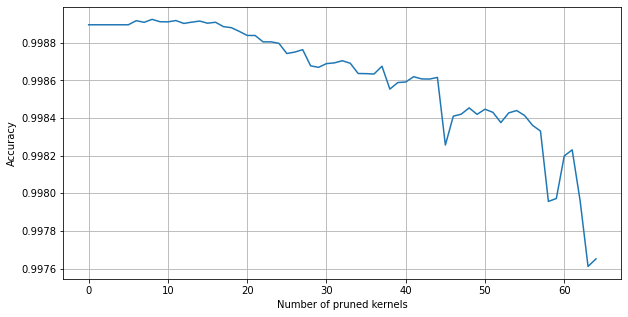

In [10]:
d = np.array( evaluation_data )
#print(d)
xvals = np.arange( d.shape[0])

plt.figure( figsize=(10,5))
plt.plot(xvals, d[:,0])
plt.grid("minor")
plt.ylabel("Accuracy")
plt.xlabel("Number of pruned kernels")
plt.savefig("accuracy_vs_pruning.png")

#plt.figure( figsize=(10,5))
##plt.errorbar(xvals, d[:,1], d[:,2])
#plt.errorbar(xvals, d[:,1])
#plt.grid("minor")
#plt.ylabel("Mean Peak position error (px)")
#plt.xlabel("Number of pruned kernels")
#plt.savefig("position_error_vs_pruning.png")

#plt.figure( figsize=(10,5))
##plt.errorbar(xvals, d[:,3], d[:,4])
#plt.errorbar(xvals, d[:,4])
#plt.grid("minor")
#plt.ylabel("Mean Peak height error (px)")
#plt.xlabel("Number of pruned kernels")
#plt.savefig("height_error_vs_pruning.png")

In [11]:
with tf.Graph().as_default():
    conv_channels = pickle.load( open("data/conv_channels.pickle","rb"))
    with tf.Graph().as_default():
        model = create_model9pk(1024, conv_channels)
        model.load_weights("data/pruned.h5")
        
        model_json = model.to_json()
        model.save_weights("data/last_model9pk_tf2_pruned.h5")
        print("Pruned model weights saved.")

        with open("data/last_model9pk_tf2_pruned.json", "w") as json_file:
            json_file.write(model_json)  
            print("Model saved to disk") 

Pruned model weights saved.
Model saved to disk


In [12]:
%load_ext autoreload
%autoreload 1
%aimport evaluator

with tf.Graph().as_default():
    from tensorflow.keras.models import model_from_json
    model = None
    with open("data/last_model9pk_tf2_pruned.json", "r") as json_file:
        loaded_model_json = json_file.read()
        model = model_from_json(loaded_model_json)

    print("Loading model weights")
    model.load_weights("data/last_model9pk_tf2_pruned.h5")

    model.summary()

    print( evaluate_dataset( "data/test_pk_100k_128.h5", model, drawplots=True, saveplots=True ) )

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Loading model weights
Model: "MODEL9pk"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1024, 1)]         0         
_________________________________________________________________
C0 (Conv1D)                  (None, 1024, 11)          44        
_________________________________________________________________
C1 (Conv1D)                  (None, 1024, 4)           136       
_________________________________________________________________
M0 (MaxPooling1D)            (None, 512, 4)            0         
_________________________________________________________________
C2 (Conv1D)                  (None, 512, 4)            52        
_________________________________________________________________
M1 (MaxPooling1D)            (None, 256, 4)            0         
______________

/DATA/miniconda3/envs/connect2/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


1.0
Confusion matrix (%):
=-=-=-=-=-=-=-=-=-=-=-
                         Yes       No   <-    Predicted peak 
Actual peak  Yes  >    1.8064     0.1388
              No  >    0.1012     97.9535

 Accuracy: 0.99760
Precision: 0.94694
   Recall: 0.92865
(0.9975999785331852, 0.9469416461535278, 0.9286540217060554)


---